# CheXpert : A Large Chest X-Ray Dataset and Competition

This competition launched by the Stanford ML group aims at finding a prediction model which could perform as well as radiologist to find different pathologies thanks to chest X-Ray. The Dataset available to train our model is composed of 223,414 chest radiographs of 65,240 patients.

<img src="view1_frontal.jpg" title="X-Ray image of the dataset" width = 320/>

The website of the competition:
https://stanfordmlgroup.github.io/competitions/chexpert/

[Publication](https://arxiv.org/pdf/1901.07031.pdf) : Irvin, Jeremy, et al. "CheXpert: A Large Chest Radiograph Dataset with Uncertainty Labels and Expert Comparison." arXiv preprint arXiv:1901.07031 (2019).

Our goal is first to reproduce main results obtained in the related paper, published in January 2019.

In [1]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

use_gpu = torch.cuda.is_available()

In [2]:
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
pathFileTrain = '../CheXpert-v1.0-small/train.csv'
pathFileValid = '../CheXpert-v1.0-small/valid.csv'

# Neural network parameters:
nnIsTrained = False                 #pre-trained using ImageNet
nnClassCount = 14                   #dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 64
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

## 1. Create a Dataset

In this first part, we create a loader able to load the data thanks to the csv files of the dataset.
This loader first load labels and paths to the different images.

It includes a pre-processing of labels to deal with uncertainty labels.
Indeed, four different labels exist:
-  **Blanks ('')**: the existence of the pathology is unknown
-  **Ones (1)**: the pathology is detected thanks to the image
-  **Zeros (0)**: the pathology can't be detected thanks to the image
-  **Uncertain (-1)**: the pathology may be detected.

In order to deal with uncertainty labels, different policies can be applied. The easiest ones consists in changing those **Uncertain** labels to *Blanks*, *Ones* or *Zeros*. This process is done thanks to the following class.

In [7]:
class CheXpertDataSet(Dataset):
    def __init__(self, image_list_file, transform=None, policy="ones"):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels
        """
        image_names = []
        labels = []

        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                image_name= line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                image_names.append('../' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

## 2. Create DataLoaders

First we define a transform model to resize all images and normalize them.

In [8]:
#TRANSFORM DATA

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
#transformList.append(transforms.Resize(imgtransCrop))
transformList.append(transforms.RandomResizedCrop(imgtransCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence=transforms.Compose(transformList)

Then we build train, validation and test data loaders. 

In [25]:
#LOAD DATASET

dataset = CheXpertDataSet(pathFileTrain ,transformSequence, policy="ones")
datasetTest, datasetTrain = random_split(dataset, [500, len(dataset) - 500])
datasetValid = CheXpertDataSet(pathFileValid, transformSequence)            
#Problèmes de l'overlapping de patients et du transform identique ?

dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=True,  num_workers=24, pin_memory=True)
dataLoaderVal = DataLoader(dataset=datasetValid, batch_size=trBatchSize, shuffle=False, num_workers=24, pin_memory=True)
dataLoaderTest = DataLoader(dataset=datasetTest, num_workers=24, pin_memory=True)

## 3. Create train and test Models

We create here a class **CheXpertTrainer** to handle the train and test processes.

In [26]:
class CheXpertTrainer():

    def train (model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, launchTimestamp, checkpoint):
        
        #SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
                
        #SETTINGS: LOSS
        loss = torch.nn.BCELoss(size_average = True)
        
        #LOAD CHECKPOINT 
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])

        
        #TRAIN THE NETWORK
        lossMIN = 100000
        
        for epochID in range(0, trMaxEpoch):
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampSTART = timestampDate + '-' + timestampTime
            
            batchs, losst, losse = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            lossVal = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)


            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            
            if lossVal < lossMIN:
                lossMIN = lossVal    
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'm-epoch'+str(epochID)+'-' + launchTimestamp + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
            else:
                print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
        
        return batchs, losst, losse        
    #-------------------------------------------------------------------------------- 
       
    def epochTrain(model, dataLoader, optimizer, epochMax, classCount, loss):
        
        batch = []
        losstrain = []
        losseval = []
        
        model.train()

        for batchID, (varInput, target) in enumerate(dataLoaderTrain):
            
            varTarget = target.cuda(non_blocking = True)
            
            #varTarget = target.cuda()         


            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            l = lossvalue.item()
            losstrain.append(l)
            
            if batchID%35==0:
                print(batchID//35, "% batches computed")
                #Fill three arrays to see the evolution of the loss


                batch.append(batchID)
                
                le = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss).item()
                losseval.append(le)
                
                print(batchID)
                print(l)
                print(le)
                
        return batch, losstrain, losseval
    
    #-------------------------------------------------------------------------------- 
    
    def epochVal(model, dataLoader, optimizer, epochMax, classCount, loss):
        
        model.eval()
        
        lossVal = 0
        lossValNorm = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):
                
                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)
                
                losstensor = loss(varOutput, target)
                lossVal += losstensor
                lossValNorm += 1
                
        outLoss = lossVal / lossValNorm
        return outLoss
    
    
    #--------------------------------------------------------------------------------     
     
    #---- Computes area under ROC curve 
    #---- dataGT - ground truth data
    #---- dataPRED - predicted data
    #---- classCount - number of classes
    
    def computeAUROC (dataGT, dataPRED, classCount):
        
        outAUROC = []
        
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
        
        
    #-------------------------------------------------------------------------------- 
    
    
    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):   
        
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):

                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                outPRED = torch.cat((outPRED, out), 0)
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        
        print ('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print (class_names[i], ' ', aurocIndividual[i])
        
        return outGT, outPRED

## 4. Train the model

In this part, we train the model and plot the loss curve.

In [12]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [13]:
# initialize and load the model
model = DenseNet121(nnClassCount).cuda()
model = torch.nn.DataParallel(model).cuda()

/home/gaetandi/miniconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch, losst, losse = CheXpertTrainer.train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, timestampLaunch, checkpoint = None)
print("Model trained")

In [ ]:
losstn = []
for i in range(0, len(losst), 35):
    losstn.append(np.mean(losst[i:i+35]))

print(losstn)
print(losse)

In [ ]:
losstn_epoch1=[0.6728807091712952, 0.43882980942726135, 0.448734313249588, 0.3944702744483948, 0.4168243706226349, 0.4108811020851135, 0.4063291847705841, 0.41022342443466187, 0.3835395276546478, 0.3770408034324646, 0.43638280034065247, 0.3838731348514557, 0.41709738969802856, 0.3788347840309143, 0.4156818389892578, 0.40620699524879456, 0.39896196126937866, 0.41358619928359985, 0.3962070047855377, 0.3510574698448181, 0.4177820384502411, 0.38106709718704224, 0.39271387457847595, 0.39069268107414246, 0.4015863239765167, 0.4040599763393402, 0.36674314737319946, 0.39783015847206116, 0.39709019660949707, 0.39561790227890015, 0.3752536475658417, 0.3812060058116913, 0.3846367299556732, 0.37263208627700806, 0.39953988790512085, 0.38198143243789673, 0.38135018944740295, 0.3660784065723419, 0.3849000930786133, 0.39580315351486206, 0.37385669350624084, 0.4011920392513275, 0.38841670751571655, 0.39842209219932556, 0.37201929092407227, 0.3926997184753418, 0.3799830377101898, 0.34905099868774414, 0.39441245794296265, 0.39433833956718445, 0.4047241806983948, 0.40487736463546753, 0.395306259393692, 0.35388389229774475, 0.4141821265220642, 0.3878190815448761, 0.40146785974502563, 0.3607812225818634, 0.42003124952316284, 0.36781835556030273, 0.4019395709037781, 0.4063832759857178, 0.40765056014060974, 0.35358932614326477, 0.3856630325317383, 0.3571811318397522, 0.40113481879234314, 0.3867679536342621, 0.381091445684433, 0.3658832609653473, 0.3639684021472931, 0.3864218294620514, 0.40048930048942566, 0.41680869460105896, 0.32693132758140564, 0.38254183530807495, 0.3829517364501953, 0.40478089451789856, 0.37888893485069275, 0.387321799993515, 0.3875291049480438, 0.3538939356803894, 0.3909098505973816, 0.3872263729572296, 0.38510894775390625, 0.36245647072792053, 0.3746325671672821, 0.38296589255332947, 0.3871270716190338, 0.3788798153400421, 0.38520655035972595, 0.3798528015613556, 0.3944593071937561, 0.38830438256263733, 0.3603636920452118, 0.38289493322372437, 0.3635413944721222, 0.38682428002357483, 0.40535497665405273, 0.3861527740955353]
losse_epoch1=[0.666441023349762, 0.443545401096344, 0.4402904808521271, 0.41923344135284424, 0.40610837936401367, 0.4354133903980255, 0.4100918173789978, 0.40635162591934204, 0.4041239321231842, 0.40100377798080444, 0.4028412401676178, 0.41881391406059265, 0.39728015661239624, 0.4003562331199646, 0.4011349081993103, 0.389141321182251, 0.4138961732387543, 0.40326550602912903, 0.40392830967903137, 0.38794854283332825, 0.40368518233299255, 0.41165873408317566, 0.38464340567588806, 0.3873163163661957, 0.41243594884872437, 0.3923010528087616, 0.40889692306518555, 0.39840763807296753, 0.3808088004589081, 0.40207257866859436, 0.4016839265823364, 0.3945044279098511, 0.3993243873119354, 0.38558343052864075, 0.3936128318309784, 0.38058415055274963, 0.3843187093734741, 0.3853977918624878, 0.37252265214920044, 0.3892264664173126, 0.377424031496048, 0.3721745014190674, 0.38715660572052, 0.3823164403438568, 0.3870171308517456, 0.3748817443847656, 0.4068020284175873, 0.3829105496406555, 0.37821173667907715, 0.38521310687065125, 0.37045013904571533, 0.37721696496009827, 0.37799766659736633, 0.38296109437942505, 0.3845213055610657, 0.38360336422920227, 0.389581561088562, 0.3840208649635315, 0.371692419052124, 0.3676907420158386, 0.3929951786994934, 0.37962183356285095, 0.3837434649467468, 0.3645118176937103, 0.3752654194831848, 0.37253111600875854, 0.40444105863571167, 0.39687687158584595, 0.38618138432502747, 0.38364624977111816, 0.38598179817199707, 0.36292433738708496, 0.39321988821029663, 0.377773642539978, 0.3815804123878479, 0.3753972351551056, 0.36458322405815125, 0.3598563075065613, 0.3723699450492859, 0.37792229652404785, 0.3774971663951874, 0.37759989500045776, 0.3747633695602417, 0.3724086284637451, 0.37157726287841797, 0.3746485710144043, 0.3860815763473511, 0.37445831298828125, 0.3731172978878021, 0.37790602445602417, 0.3680556118488312, 0.3752572536468506, 0.38026267290115356, 0.3717893660068512, 0.38101106882095337, 0.39427292346954346, 0.3680296540260315, 0.3675823509693146, 0.37638282775878906, 0.3839713931083679]
losstn_epoch3=[0.38051341261182514, 0.3658151320048741, 0.3639340903077807, 0.36485876781599863, 0.36685000828334263, 0.36836428812571936, 0.36756816591535296, 0.37124566435813905, 0.3681624037878854, 0.374736567905971, 0.3687584051064083, 0.36424035004207067, 0.3703120163508824, 0.36894939371517727, 0.36022033776555745, 0.3673130282333919, 0.36186509132385253, 0.36625950591904777, 0.36297464541026525, 0.3693518894059317, 0.3638090704168592, 0.3724226270403181, 0.3640745290688106, 0.36675788845334734, 0.37345966952187676, 0.3731388449668884, 0.3684110530785152, 0.3639200483049665, 0.3651915967464447, 0.3642853558063507, 0.36709401862961905, 0.3581216607775007, 0.3665789927755083, 0.37044233764920914, 0.37035551071166994, 0.36115669693265645, 0.3659857843603407, 0.36471542205129354, 0.3732741628374372, 0.35643954532487054, 0.3610902275357928, 0.36244546345302037, 0.3705384876046862, 0.36581030913761686, 0.36329577224595205, 0.3676545509270259, 0.36561696444238934, 0.3715359585625785, 0.3667013849530901, 0.36900477239063806, 0.36954912798745293, 0.36849043113844737, 0.3635358742305211, 0.3630792072841099, 0.36973476580211095, 0.36799241048949105, 0.37081386361803326, 0.3732601353100368, 0.36271968143326894, 0.36498962811061314, 0.36406879680497306, 0.36553994587489536, 0.365545151914869, 0.3638610405581338, 0.36712174671036857, 0.3647415110043117, 0.3593090295791626, 0.364276260137558, 0.3680364796093532, 0.36656315071242196, 0.3626070507935115, 0.3716740327222007, 0.36098582829747883, 0.3648436026913779, 0.3675053102629525, 0.3685786187648773, 0.36340729338782174, 0.36737111892019, 0.3632750562259129, 0.3605492753641946, 0.36383285863058906, 0.36517225589071, 0.3623916736670903, 0.36308704274041315, 0.36442938191550117, 0.368915627683912, 0.3678668558597565, 0.36115385038512093, 0.36148552213396346, 0.37054748705455237, 0.36789325305393766, 0.3748648260320936, 0.36340012550354006, 0.3641108529908316, 0.36615062355995176, 0.36815079024859837, 0.3645210334232875, 0.35988654323986596, 0.36429472480501446, 0.3669776069490533]
losse_epoch3=[0.38220077753067017, 0.36867281794548035, 0.3660353422164917, 0.36900028586387634, 0.3711201846599579, 0.3655049204826355, 0.38020920753479004, 0.39028123021125793, 0.37177467346191406, 0.37435629963874817, 0.3705317974090576, 0.3639028072357178, 0.39185965061187744, 0.3511858880519867, 0.35681474208831787, 0.35532692074775696, 0.3627282381057739, 0.3618534505367279, 0.3722829520702362, 0.3830084204673767, 0.3599976599216461, 0.3555195927619934, 0.3844893276691437, 0.3682909607887268, 0.3684101998806, 0.37029096484184265, 0.35533377528190613, 0.37213096022605896, 0.3589882552623749, 0.3597415089607239, 0.36184340715408325, 0.3692008852958679, 0.35744544863700867, 0.36229392886161804, 0.3801175355911255, 0.3745628297328949, 0.3687003552913666, 0.3584973216056824, 0.3748897910118103, 0.3729517161846161, 0.38276320695877075, 0.36764630675315857, 0.35325735807418823, 0.36001384258270264, 0.36614522337913513, 0.3841313421726227, 0.36138278245925903, 0.3616596758365631, 0.36090826988220215, 0.35949522256851196, 0.366208016872406, 0.35931190848350525, 0.36841779947280884, 0.3730843961238861, 0.37996459007263184, 0.3785761892795563, 0.3619198501110077, 0.3738425076007843, 0.3708505928516388, 0.37567031383514404, 0.36326074600219727, 0.36674362421035767, 0.37249255180358887, 0.37204915285110474, 0.3596794307231903, 0.3720349073410034, 0.3716083765029907, 0.37923040986061096, 0.36696857213974, 0.3702094554901123, 0.3445281982421875, 0.3790825605392456, 0.36396098136901855, 0.37183332443237305, 0.35958412289619446, 0.35418984293937683, 0.36632266640663147, 0.3817428648471832, 0.3600780665874481, 0.3652954697608948, 0.3680856227874756, 0.36333996057510376, 0.3624174892902374, 0.35192856192588806, 0.37317466735839844, 0.366635799407959, 0.36577141284942627, 0.3535260260105133, 0.37028968334198, 0.36776190996170044, 0.37093037366867065, 0.3615829348564148, 0.3563258945941925, 0.36758214235305786, 0.367106556892395, 0.3587679862976074, 0.35876262187957764, 0.375153124332428, 0.3622967600822449, 0.35854095220565796]
losstn_epoch4=[0.3755222601549966, 0.3784257403441838, 0.37199340207236153, 0.36978330186435154, 0.36198908260890417, 0.36512007713317873, 0.3724356710910797, 0.3706600819315229, 0.3702239385672978, 0.3661889638219561, 0.36683198043278287, 0.37235393013272966, 0.3589568998132433, 0.3672996435846601, 0.37171386906078885, 0.3667326067175184, 0.36750412583351133, 0.37057874373027255, 0.36593369330678666, 0.3689162169184004, 0.3677746730191367, 0.3711091901574816, 0.3636417099407741, 0.3600289949348995, 0.36938585894448417, 0.36420794810567586, 0.3706305180277143, 0.36743602582386564, 0.36928934029170446, 0.36655380385262626, 0.369582508291517, 0.363459323985236, 0.36473134585789274, 0.3643632539681026, 0.3645498973982675, 0.367677617924554, 0.36294596450669425, 0.3649484123502459, 0.3672070520264762, 0.3604582037244524, 0.3715140972818647, 0.3678193083831242, 0.3703582840306418, 0.36620077320507594, 0.36435710532324656, 0.36139639019966124, 0.3614156757082258, 0.3640026160648891, 0.36829948340143476, 0.36270844510623385, 0.3669466529573713, 0.3613880055291312, 0.36768755572182793, 0.3658126550061362, 0.36566672921180726, 0.36304661546434674, 0.3676025126661573, 0.3671888198171343, 0.3643344274588994, 0.3697093095098223, 0.36672653555870055, 0.3648584204060691, 0.361837694474629, 0.36776683585984365, 0.366360707793917, 0.3704585577760424, 0.366515988111496, 0.3703383113656725, 0.3650380628449576, 0.36242629715374536, 0.3673528833048684, 0.36392075760023934, 0.3616450105394636, 0.360330206155777, 0.36924799765859334, 0.36156031233923774, 0.3570254283291953, 0.3638030580111912, 0.3631406043257032, 0.36772392732756476, 0.361017632484436, 0.36461744563920157, 0.3694217724459512, 0.36860319801739283, 0.36231802446501593, 0.3680333375930786, 0.36263706769262044, 0.3654853207724435, 0.360782813174384, 0.36573885423796515, 0.3642277411052159, 0.3636784127780369, 0.3588270562035697, 0.3651413210800716, 0.369293498141425, 0.3644505900996072, 0.37127330388341634, 0.3647752446787698, 0.3630945767675127, 0.367661294184233]
losse_epoch4=[0.3805544376373291, 0.3734971880912781, 0.36626899242401123, 0.35748544335365295, 0.36400526762008667, 0.3787081241607666, 0.3638656437397003, 0.3576703667640686, 0.38581162691116333, 0.3661232590675354, 0.3793403208255768, 0.36817827820777893, 0.37447163462638855, 0.3862340748310089, 0.36480140686035156, 0.3756641149520874, 0.37262284755706787, 0.3616373836994171, 0.3729729652404785, 0.37484994530677795, 0.36986684799194336, 0.3685488998889923, 0.3741607666015625, 0.36320504546165466, 0.36459749937057495, 0.36150071024894714, 0.3663293719291687, 0.3677067756652832, 0.36079493165016174, 0.3643547296524048, 0.37375548481941223, 0.38259708881378174, 0.3698703348636627, 0.36249879002571106, 0.3682171106338501, 0.37289685010910034, 0.3643338084220886, 0.3503931760787964, 0.35800397396087646, 0.37068215012550354, 0.3663598299026489, 0.36005282402038574, 0.3523160517215729, 0.3677838146686554, 0.380155086517334, 0.3665335476398468, 0.3614148199558258, 0.37214916944503784, 0.36093658208847046, 0.3762131929397583, 0.3783797025680542, 0.35905662178993225, 0.37995249032974243, 0.37668076157569885, 0.38223373889923096, 0.37231114506721497, 0.3603467345237732, 0.370810866355896, 0.3650743067264557, 0.36823880672454834, 0.3672899007797241, 0.36728230118751526, 0.3726865351200104, 0.3651810884475708, 0.3621949851512909, 0.3773549795150757, 0.37333834171295166, 0.3696346879005432, 0.3683282136917114, 0.35838863253593445, 0.3678383529186249, 0.36495712399482727, 0.3637832701206207, 0.37923842668533325, 0.3564605116844177, 0.36124280095100403, 0.3723773658275604, 0.37706851959228516, 0.37291762232780457, 0.3775297999382019, 0.36428314447402954, 0.3726186752319336, 0.37324127554893494, 0.3584378957748413, 0.379909873008728, 0.3619231879711151, 0.36706364154815674, 0.3745215833187103, 0.36760541796684265, 0.3831001818180084, 0.37397828698158264, 0.35005122423171997, 0.37429487705230713, 0.3595587909221649, 0.3598985970020294, 0.3776772916316986, 0.37782102823257446, 0.3772406578063965, 0.374235600233078, 0.35852670669555664]

In [ ]:
lt = losstn_epoch1 + losstn_epoch3 + losstn_epoch4
le = losse_epoch1 + losse_epoch3 + losse_epoch4 
batch = [i*35 for i in range(len(lt))]

plt.plot(batch, lt, label = "train")
plt.plot(batch, le, label = "eval")
plt.xlabel("Nb of batches (size_batch = 64)")
plt.ylabel("BCE loss")
plt.title("BCE loss evolution")
plt.legend()

plt.savefig("chart5.png", dpi=1000)
plt.show()

## 5. Test and ROC Curves

In this part, we test our different models on a test set.

We also plot the ROC Curves (Receiver operating characteristic).
The metric used to evaluate the performances of our model is the AUROC : **Area Under The Roc Curve**.

In [ ]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

outGT1, outPRED1 = CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, "model1.pth.tar", class_names)
outGT3, outPRED3 = CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, "model_zeros.pth.tar", class_names)
#outGT4, outPRED4 = CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, "model4.pth.tar", class_names)

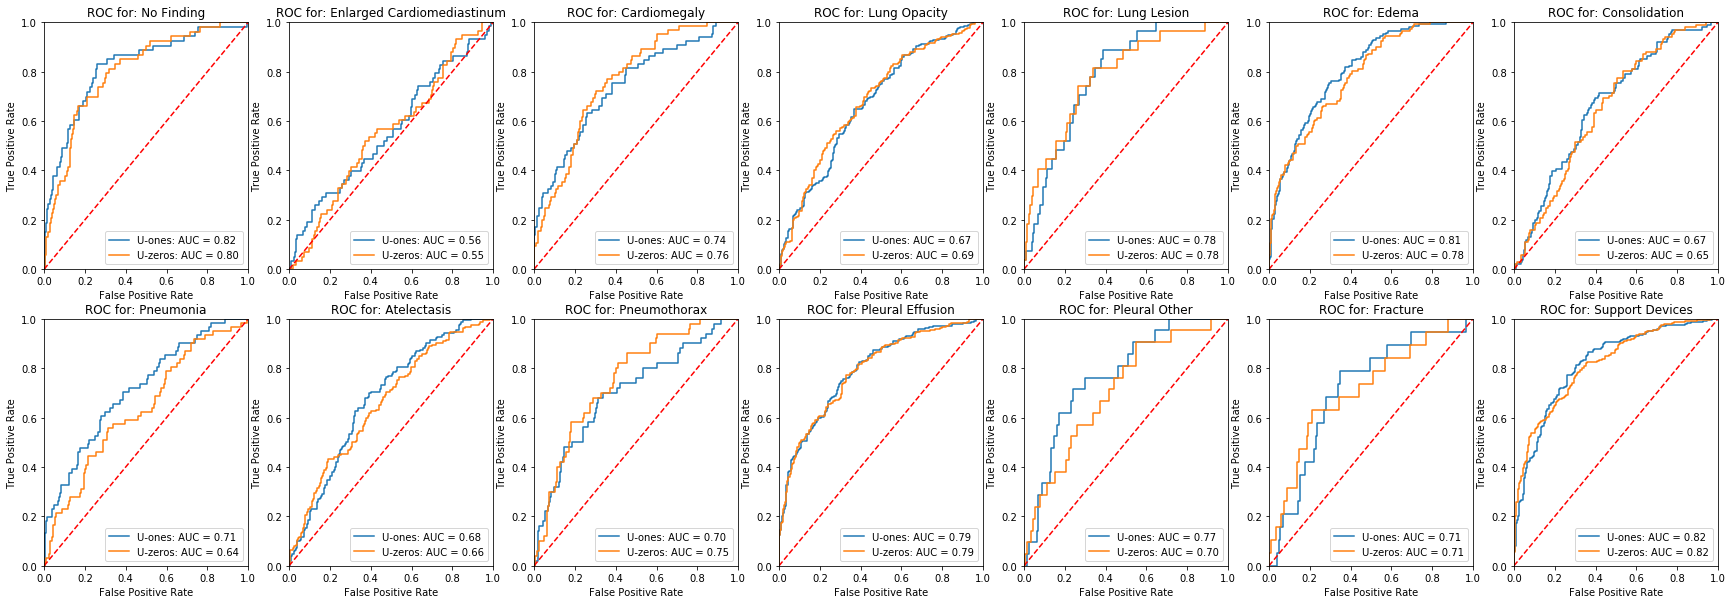

In [28]:
for i in range(nnClassCount):
    fpr, tpr, threshold = metrics.roc_curve(outGT1.cpu()[:,i], outPRED1.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    fpr2, tpr2, threshold2 = metrics.roc_curve(outGT3.cpu()[:,i], outPRED3.cpu()[:,i])
    roc_auc2 = metrics.auc(fpr2, tpr2)
    #fpr3, tpr3, threshold2 = metrics.roc_curve(outGT4.cpu()[:,i], outPRED4.cpu()[:,i])
    #roc_auc3 = metrics.auc(fpr3, tpr3)


    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)
    plt.plot(fpr2, tpr2, label = 'U-zeros: AUC = %0.2f' % roc_auc2)
    #plt.plot(fpr3, tpr3, label = 'AUC = %0.2f' % roc_auc3)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.savefig("ROC1345.png", dpi=1000)
plt.show()

## 6. Heatmap generator

In [ ]:
class HeatmapGenerator ():
    
    #---- Initialize heatmap generator
    #---- pathModel - path to the trained densenet model
    #---- nnArchitecture - architecture name DENSE-NET121, DENSE-NET169, DENSE-NET201
    #---- nnClassCount - class count, 14 for chxray-14

 
    def __init__ (self, pathModel, nnClassCount, transCrop):
       
        #---- Initialize the network
        model = DenseNet121(nnClassCount).cuda()
        
        if use_gpu:
            model = torch.nn.DataParallel(model).cuda()
        else:
            model = torch.nn.DataParallel(model)
        
        modelCheckpoint = torch.load(pathModel)
        model.load_state_dict(modelCheckpoint['state_dict'])

        self.model = model
        self.model.eval()
        
        #---- Initialize the weights
        self.weights = list(self.model.module.densenet121.features.parameters())[-2]

        #---- Initialize the image transform
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transformList = []
        transformList.append(transforms.Resize((transCrop, transCrop)))
        transformList.append(transforms.ToTensor())
        transformList.append(normalize)  
        self.transformSequence = transforms.Compose(transformList)
    
    #--------------------------------------------------------------------------------
     
    def generate (self, pathImageFile, pathOutputFile, transCrop):
        
        #---- Load image, transform, convert 
        with torch.no_grad():
 
            imageData = Image.open(pathImageFile).convert('RGB')
            imageData = self.transformSequence(imageData)
            imageData = imageData.unsqueeze_(0)
            if use_gpu:
                imageData = imageData.cuda()
            l = self.model(imageData)
            output = self.model.module.densenet121.features(imageData)
            label = class_names[torch.max(l,1)[1]]
            #---- Generate heatmap
            heatmap = None
            for i in range (0, len(self.weights)):
                map = output[0,i,:,:]
                if i == 0: heatmap = self.weights[i] * map
                else: heatmap += self.weights[i] * map
                npHeatmap = heatmap.cpu().data.numpy()

        #---- Blend original and heatmap 
                
        imgOriginal = cv2.imread(pathImageFile, 1)
        imgOriginal = cv2.resize(imgOriginal, (transCrop, transCrop))
        
        cam = npHeatmap / np.max(npHeatmap)
        cam = cv2.resize(cam, (transCrop, transCrop))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        
        img = cv2.addWeighted(imgOriginal,1,heatmap,0.35,0)            
        cv2.imwrite(pathOutputFile, img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.title(label)
        plt.imshow(img)
        plt.plot()



In [ ]:
pathInputImage = '../CheXpert-v1.0-small/valid/patient64698/study1/view1_frontal.jpg'
pathOutputImage = 'heatmap_patient64698_1.png'
pathModel = "model4.pth.tar"


h = HeatmapGenerator(pathModel, nnClassCount, imgtransCrop)

h.generate(pathInputImage, pathOutputImage, imgtransCrop)